In [2]:
# Import all the necessary modules
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import pandas_datareader as pdr
import math
import datetime
import itertools
import ast
import yfinance as yf
import seaborn as sn
from IPython.display import display, HTML
from trend_following_signal import (apply_jupyter_fullscreen_css, load_financial_data, get_returns_volatility, calculate_slope, trend_signal, slope_signal, 
                             create_trend_strategy, get_close_prices, calculate_donchian_channels)
from strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
import coinbase_utils as cn
import strategy_performance as perf
import position_sizing_binary_utils as size_bin
import position_sizing_continuous_utils as size_cont
import trend_following_signal as tf
%matplotlib inline

In [3]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size_bin)
importlib.reload(size_cont)

<module 'position_sizing_continuous_utils' from '/Users/adheerchauhan/Documents/git/trend_following/position_sizing_continuous_utils.py'>

In [4]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

In [5]:
from strategy_performance import calculate_risk_and_performance_metrics

import seaborn as sns

def plot_moving_avg_crossover_performance_heatmap(df_performance):
    unique_step_sizes = df_performance['stepsize'].unique()

    # Plotting each heatmap in a loop
    for step in unique_step_sizes:
        subset = df_performance[df_performance['stepsize'] == step]
        pivoted_df_sharpe = subset.pivot(index='slow_mavg', columns='fast_mavg', values='sharpe_ratio')
        pivoted_df_calmar = subset.pivot(index='slow_mavg', columns='fast_mavg', values='calmar_ratio')
        pivoted_df_return = subset.pivot(index='slow_mavg', columns='fast_mavg', values='annualized_return')
        
        fig = plt.figure(figsize=(30,6))
        # plt.style.use('bmh')
        layout = (1,3)
        sharpe_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
        calmar_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
        return_ax = plt.subplot2grid(layout, (0,2))#, colspan=2)

        sns.heatmap(pivoted_df_sharpe, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=sharpe_ax)
        _ = sharpe_ax.set_title(f'Sharpe Ratio Heatmap\nStep Size: {step}')
        _ = sharpe_ax.set_ylabel('Slow Moving Average (Days)')
        _ = sharpe_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_calmar, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=calmar_ax)
        _ = calmar_ax.set_title(f'Calmar Ratio Heatmap\nStep Size: {step}')
        _ = calmar_ax.set_ylabel('Slow Moving Average (Days)')
        _ = calmar_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_return, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=return_ax)
        _ = return_ax.set_title(f'Annualized Return Heatmap\nStep Size: {step}')
        _ = return_ax.set_ylabel('Slow Moving Average (Days)')
        _ = return_ax.set_xlabel('Fast Moving Average (Days)')

        plt.tight_layout()
    
    return

def moving_avg_crossover_strategy_performance(start_date, end_date, ticker_list, fast_mavg_list=np.arange(10, 101, 10), slow_mavg_list=np.arange(50, 501, 50), rolling_donchian_window=20, long_only=True,
                                              initial_capital=15000, rolling_cov_window=20, volatility_window=20, transaction_cost_est=0.001, passive_trade_rate=0.05, use_coinbase_data=True,
                                              rolling_sharpe_window=50, cash_buffer_percentage=0.10, annualized_target_volatility=0.20, annual_trading_days=365, use_specific_start_date=False,
                                              signal_start_date=None):
    
    perf_cols = ['fast_mavg', 'slow_mavg', 'stepsize', 'annualized_return', 'sharpe_ratio', 'calmar_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration',
                'hit_rate', 't_statistic', 'p_value', 'trade_count']
    df_performance = pd.DataFrame(columns=perf_cols)
    
    mavg_stepsize_list = [2, 4, 6, 8]
    for slow_mavg in slow_mavg_list:
        for fast_mavg in fast_mavg_list:
            for stepsize in mavg_stepsize_list:
                if fast_mavg < slow_mavg:
                    df = size.apply_target_volatility_position_sizing_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg,
                                                                               mavg_stepsize, rolling_donchian_window, long_only, initial_capital,
                                                                               rolling_cov_window, volatility_window, transaction_cost_est, passive_trade_rate,
                                                                               use_coinbase_data, rolling_sharpe_window, cash_buffer_percentage, annualized_target_volatility,
                                                                               annual_trading_days, use_specific_start_date, signal_start_date)
                    performance_metrics = calculate_risk_and_performance_metrics(df, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                                passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
                    row = {
                        # 'ticker': ticker,
                        'fast_mavg': fast_mavg,
                        'slow_mavg': slow_mavg,
                        'stepsize': stepsize,
                        'annualized_return': performance_metrics['annualized_return'],
                        'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
                        'calmar_ratio': performance_metrics['calmar_ratio'],
                        'annualized_std_dev': performance_metrics['annualized_std_dev'],
                        'max_drawdown': performance_metrics['max_drawdown'],
                        'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
                        'hit_rate': performance_metrics['hit_rate'],
                        't_statistic': performance_metrics['t_statistic'],
                        'p_value': performance_metrics['p_value'],
                        'trade_count': performance_metrics['trade_count']
                    }
                    df_performance = pd.concat([df_performance, pd.DataFrame([row])], ignore_index=True)
    
    return df_performance

In [6]:
def plot_trend_following_performance_time_series(df, df_trend, start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, price_or_returns_calc, rolling_donchian_window, rolling_sharpe_window):
    
    start_date = pd.to_datetime(start_date).date().strftime('%Y-%m-%d')
    end_date = pd.to_datetime(end_date).date().strftime('%Y-%m-%d')
    fig = plt.figure(figsize=(22,20))
    layout = (5,2)
    trend_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    trend_donchian_ax = plt.subplot2grid(layout, (1,0), colspan=2)
    trend_signal_ax = plt.subplot2grid(layout, (2,0), colspan=2)
    trend_signal_ax2 = trend_signal_ax.twinx()
    trend_rolling_sharpe_ax = plt.subplot2grid(layout, (3,0), colspan=2)
    trend_return_ax = plt.subplot2grid(layout, (4,0))#, colspan=2)
    trend_cum_return_ax = plt.subplot2grid(layout, (4,1))#, colspan=2)

    _ = trend_ax.plot(df.index, df[f'{ticker}_t_1_close'], label='Price')
    for mavg in np.linspace(fast_mavg, slow_mavg, mavg_stepsize):
        _ = trend_ax.plot(df_trend.index, df_trend[f'{ticker}_{int(mavg)}_mavg'], label=f'{mavg} M Avg')

    _ = trend_ax.set_title(f'{ticker} Moving Average Ribbons - {start_date} - {end_date}')
    _ = trend_ax.set_ylabel('Price')
    _ = trend_ax.set_xlabel('Date')
    _ = trend_ax.legend(loc='upper left')
    _ = trend_ax.grid()

    _ = trend_donchian_ax.plot(df.index, df[f'{ticker}_t_1_close'], label='Price')
    _ = trend_donchian_ax.plot(df.index,
                      df[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'], label='Donchian Upper Band', linestyle='--', linewidth=3)
    _ = trend_donchian_ax.plot(df.index,
                      df[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'], label='Donchian Lower Band', linestyle='--', linewidth=3)

    _ = trend_donchian_ax.set_title(f'{ticker} Donchian Channels')
    _ = trend_donchian_ax.set_ylabel('Price')
    _ = trend_donchian_ax.set_xlabel('Date')
    _ = trend_donchian_ax.legend(loc='upper left')
    _ = trend_donchian_ax.grid()

    _ = trend_signal_ax.plot(df.index,
                             df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'], label='Signal')
    _ = trend_signal_ax2.plot(df.index, df[f'{ticker}_t_1_close'], label='Price', alpha=0.8, color='orange', linestyle='--')
    _ = trend_signal_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Signal')
    _ = trend_signal_ax.set_ylabel('Signal')
    _ = trend_signal_ax.set_xlabel('Date')
    _ = trend_signal_ax.legend(loc='upper left')
    _ = trend_signal_ax.grid()

    _ = trend_rolling_sharpe_ax.plot(df.index, df[f'portfolio_rolling_sharpe_50'],
                                     # df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_rolling_sharpe_{rolling_sharpe_window}'],
                                     label='Sharpe Ratio', color='orange')
    _ = trend_rolling_sharpe_ax.set_title(f'{ticker} Rolling Sharpe Ratio')
    _ = trend_rolling_sharpe_ax.set_ylabel('Sharpe Ratio')
    _ = trend_rolling_sharpe_ax.set_xlabel('Date')
    _ = trend_rolling_sharpe_ax.legend(loc='upper left')
    _ = trend_rolling_sharpe_ax.grid()

    _ = trend_return_ax.plot(df.index, df[f'portfolio_daily_pct_returns'],
                             # df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'],
                             label='Return')
    _ = trend_return_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Return')
    _ = trend_return_ax.set_ylabel('Return')
    _ = trend_return_ax.set_xlabel('Date')
    _ = trend_return_ax.legend(loc='upper left')
    _ = trend_return_ax.grid()

    # _ = trend_cum_return_ax.plot(df_trend_mavg_donchian.index, df_trend_mavg_donchian[f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_cum'], label='Cum. Return')
    _ = trend_cum_return_ax.plot(df.index, df['strategy_cumulative_return'], label='Cum. Return')
    _ = trend_cum_return_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Cumulative Return')
    _ = trend_cum_return_ax.set_ylabel('Cum. Return')
    _ = trend_cum_return_ax.set_xlabel('Date')
    _ = trend_cum_return_ax.legend(loc='upper left')
    _ = trend_cum_return_ax.grid()


    plt.tight_layout()
    
    return

## Save Crypto Data from Coinbase

In [8]:
ticker_list_save = ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD','XRP-USD','AAVE-USD','MATIC-USD']

In [ ]:
for ticker in ticker_list_save:
    print(ticker)
    df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=False, start_date=None, 
                                                        end_date=pd.Timestamp('2025-06-30').date(), save_to_file=True)

## Trend Following Signal - Moving Average and Donchian Channel

In [16]:
from collections import OrderedDict

def print_strategy_params():
    """
    Pretty-print the strategy’s configuration values, with a blank line
    separating each logical section.
    """

    # ---- Define sections (title is just for dev readability) --------------
    sections = [
        ("Dates & universe", OrderedDict([
            ("start_date",  start_date),
            ("end_date",    end_date),
            ("ticker_list", ticker_list),
        ])),

        ("Moving-average / trend", OrderedDict([
            ("fast_mavg",                  fast_mavg),
            ("slow_mavg",                  slow_mavg),
            ("mavg_stepsize",              mavg_stepsize),
            ("fast_mavg_log",                  fast_mavg_log),
            ("slow_mavg_log",                  slow_mavg_log),
            ("mavg_stepsize_log",              mavg_stepsize_log),
            ("moving_avg_type",            moving_avg_type),
            ("ma_crossover_signal_weight", ma_crossover_signal_weight),
        ])),

        ("Donchian channel", OrderedDict([
            ("entry_rolling_donchian_window", entry_rolling_donchian_window),
            ("exit_rolling_donchian_window", exit_rolling_donchian_window),
            ("use_donchian_exit_gate", use_donchian_exit_gate),
            ("donchian_signal_weight",  donchian_signal_weight),
        ])),

        ("Volatility & risk", OrderedDict([
            ("volatility_window",            volatility_window),
            ("annualized_target_volatility", annualized_target_volatility),
            ("rolling_cov_window",           rolling_cov_window),
            ("rolling_atr_window",           rolling_atr_window),
            ("atr_multiplier",               atr_multiplier),
            ("vol_of_vol_window_1",          vol_of_vol_window_1),
            ("vol_of_vol_window_2",          vol_of_vol_window_2),
            ("vol_of_vol_z_score_window",    vol_of_vol_z_score_window),
        ])),

        ("Signal gating / quality", OrderedDict([
            ("lower_r_sqr_limit",   lower_r_sqr_limit),
            ("upper_r_sqr_limit",   upper_r_sqr_limit),
            ("r2_window",           r2_window),
            ("rolling_sharpe_window", rolling_sharpe_window),
        ])),

        ("Trading toggles & thresholds", OrderedDict([
            ("long_only",                 long_only),
            ("use_coinbase_data",         use_coinbase_data),
            ("use_saved_files",           use_saved_files),
            ("saved_file_end_date",       saved_file_end_date),
            ("use_specific_start_date",   use_specific_start_date),
            ("signal_start_date",         signal_start_date),
            ("price_or_returns_calc",     price_or_returns_calc),
            ("notional_threshold_pct",    notional_threshold_pct),
            ("cooldown_counter_threshold", cooldown_counter_threshold),
        ])),

        ("Capital & execution", OrderedDict([
            ("initial_capital",        initial_capital),
            ("cash_buffer_percentage", cash_buffer_percentage),
            ("transaction_cost_est",   transaction_cost_est),
            ("passive_trade_rate",     passive_trade_rate),
            ("annual_trading_days",    annual_trading_days),
        ])),
    ]

    # ---- Compute width for neat alignment ---------------------------------
    longest_key = max(len(k) for _, sec in sections for k in sec)

    print("\nStrategy Parameters\n" + "-" * (longest_key + 30))
    for _, sec in sections:
        for k, v in sec.items():
            print(f"{k:<{longest_key}} : {v}")
        print()  # blank line between sections
    print("-" * (longest_key + 30) + "\n")

# ---------------------------------------------------------------------------
# Example usage (uncomment after your own parameter definitions are in scope)
# ---------------------------------------------------------------------------
# if __name__ == "__main__":
#     print_strategy_params()

In [18]:
def plot_signal_performance(df_1, df_2, ticker):

    fig = plt.figure(figsize=(20,12))
    layout = (2,2)
    signal_ax = plt.subplot2grid(layout, (0,0))
    price_ax = signal_ax.twinx()
    equity_curve_ax = plt.subplot2grid(layout, (0,1))
    sharpe_ax = plt.subplot2grid(layout, (1,0))
    portfolio_value_ax = plt.subplot2grid(layout, (1,1))

    _ = signal_ax.plot(df_1.index, df_1[f'{ticker}_final_signal'], label='Orig Signal', alpha=0.9)
    _ = signal_ax.plot(df_2.index, df_2[f'{ticker}_final_signal'], label='New Signal', alpha=0.9)
    _ = price_ax.plot(df_1.index, df_2[f'{ticker}_open'], label='Price', alpha=0.7, linestyle='--', color='magenta')
    _ = signal_ax.set_title(f'Orignal Signal vs New Signal')
    _ = signal_ax.set_ylabel('Signal')
    _ = signal_ax.set_xlabel('Date')
    _ = signal_ax.legend(loc='upper left')
    _ = signal_ax.grid()

    _ = equity_curve_ax.plot(df_1.index, df_1[f'equity_curve'], label='Orig Signal', alpha=0.9)
    _ = equity_curve_ax.plot(df_2.index, df_2[f'equity_curve'], label='New Signal', alpha=0.9)
    _ = equity_curve_ax.set_title(f'Equity Curve')
    _ = equity_curve_ax.set_ylabel('Equity Curve')
    _ = equity_curve_ax.set_xlabel('Date')
    _ = equity_curve_ax.legend(loc='upper left')
    _ = equity_curve_ax.grid()

    _ = sharpe_ax.plot(df_1.index, df_1[f'portfolio_rolling_sharpe_50'], label='Orig Signal', alpha=0.9)
    _ = sharpe_ax.plot(df_2.index, df_2[f'portfolio_rolling_sharpe_50'], label='New Signal', alpha=0.9)
    _ = sharpe_ax.set_title(f'Rolling Sharpe')
    _ = sharpe_ax.set_ylabel(f'Rolling Sharpe')
    _ = sharpe_ax.set_xlabel('Date')
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.grid()

    _ = portfolio_value_ax.plot(df_1.index, df_1[f'total_portfolio_value'], label='Orig Signal', alpha=0.9)
    _ = portfolio_value_ax.plot(df_2.index, df_2[f'total_portfolio_value'], label='New Signal', alpha=0.9)
    _ = portfolio_value_ax.set_title(f'Total Portfolio Value')
    _ = portfolio_value_ax.set_ylabel('Portfolio Value')
    _ = portfolio_value_ax.set_xlabel('Date')
    _ = portfolio_value_ax.legend(loc='upper left')
    _ = portfolio_value_ax.grid()

    plt.tight_layout()

    return

In [20]:
from scipy.stats import linregress

def calc_ribbon_slope(row, ticker, fast_mavg, slow_mavg, mavg_stepsize):
    x = np.linspace(slow_mavg, fast_mavg, mavg_stepsize)
    y = row.values
    slope, _, _, _, _ = linregress(x, y)
    return slope

In [22]:
def pct_rank(x, window=250):
    return x.rank(pct=True)

In [24]:
def calculate_average_directional_index(start_date, end_date, ticker, adx_period):
    
    ## Convert number of bars to days. ## alpha = 2/(span + 1) for the Exponentially Weighted Average
    ## If alpha = 1/n, span = 2*n - 1
    adx_atr_window = 2*adx_period - 1

    ## Pull Market Data
    if use_coinbase_data:
        # df = cn.get_coinbase_ohlc_data(ticker=ticker)
        df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, end_date=end_date, save_to_file=False)
        df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
        df.columns = [f'{ticker}_{x}' for x in df.columns]
    else:
        df = tf.load_financial_data(start_date, end_date, ticker, print_status=False)  # .shift(1)
        df.columns = [f'{ticker}_open', f'{ticker}_high', f'{ticker}_low', f'{ticker}_close', f'{ticker}_adjclose',
                      f'{ticker}_volume']
    
    ## Calculate Directional Move
    df[f'{ticker}_up_move'] = df[f'{ticker}_high'].diff()
    df[f'{ticker}_down_move'] = -df[f'{ticker}_low'].diff()
    
    plus_dir_move_cond = (df[f'{ticker}_up_move'] > df[f'{ticker}_down_move']) & (df[f'{ticker}_up_move'] > 0)
    minus_dir_move_cond = (df[f'{ticker}_down_move'] > df[f'{ticker}_up_move']) & (df[f'{ticker}_down_move'] > 0)
    df[f'{ticker}_plus_dir_move'] = np.where(plus_dir_move_cond, df[f'{ticker}_up_move'], 0)
    df[f'{ticker}_minus_dir_move'] = np.where(minus_dir_move_cond, df[f'{ticker}_down_move'], 0)
    
    ## Calculate the True Range (TR) and Average True Range (ATR)
    df[f'{ticker}_high-low'] = df[f'{ticker}_high'] - df[f'{ticker}_low']
    df[f'{ticker}_high-close'] = np.abs(df[f'{ticker}_high'] - df[f'{ticker}_close'].shift(1))
    df[f'{ticker}_low-close'] = np.abs(df[f'{ticker}_low'] - df[f'{ticker}_close'].shift(1))
    df[f'{ticker}_true_range_price'] = df[[f'{ticker}_high-low',f'{ticker}_high-close', f'{ticker}_low-close']].max(axis=1)
    df[f'{ticker}_{adx_atr_window}_avg_true_range'] = df[f'{ticker}_true_range_price'].ewm(span=adx_atr_window, adjust=False).mean()
    
    ## Calculate the exponentially weighted directional moves
    df[f'{ticker}_plus_dir_move_exp'] = df[f'{ticker}_plus_dir_move'].ewm(span=adx_atr_window, adjust=False).mean()
    df[f'{ticker}_minus_dir_move_exp'] = df[f'{ticker}_minus_dir_move'].ewm(span=adx_atr_window, adjust=False).mean()
    
    ## Calculate the directional indicator
    df[f'{ticker}_plus_dir_ind'] = 100 * (df[f'{ticker}_plus_dir_move_exp'] / df[f'{ticker}_{adx_atr_window}_avg_true_range'])
    df[f'{ticker}_minus_dir_ind'] = 100 * (df[f'{ticker}_minus_dir_move_exp'] / df[f'{ticker}_{adx_atr_window}_avg_true_range'])
    df[f'{ticker}_dir_ind'] = 100 * np.abs((df[f'{ticker}_plus_dir_ind'] - df[f'{ticker}_minus_dir_ind'])) / (df[f'{ticker}_plus_dir_ind'] + df[f'{ticker}_minus_dir_ind'])
    df[f'{ticker}_avg_dir_ind'] = df[f'{ticker}_dir_ind'].ewm(span=adx_atr_window, adjust=False).mean()
    
    ## Shift by a day to avoid look-ahead bias
    df[f'{ticker}_avg_dir_ind'] = df[f'{ticker}_avg_dir_ind'].shift(1)

    return df[[f'{ticker}_avg_dir_ind']]

In [26]:
def calculate_rolling_r2(df, ticker, t_1_close_price_col, r2_window=50, lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.8):

    log_price_col = f'{ticker}_t_1_close_price_log'
    df[log_price_col] = np.log(df[t_1_close_price_col])
    
    ## Define the variables
    y = df[log_price_col]
    x = np.arange(len(y), dtype=float) # Time

    ## Compute rolling sums for rolling R2 calculation
    x_sum = pd.Series(x, y.index).rolling(r2_window).sum()
    y_sum = y.rolling(r2_window).sum()
    x_sqr = pd.Series(x**2, y.index).rolling(r2_window).sum()
    y_sqr = (y**2).rolling(r2_window).sum()
    xy_sum = pd.Series(x, y.index).mul(y).rolling(r2_window).sum()

    ## Calculate the R squared
    n = r2_window
    numerator = n * xy_sum - x_sum * y_sum
    denominator = np.sqrt((n * x_sqr) - (x_sum ** 2)) * np.sqrt((n * y_sqr) - (y_sum**2))
    df[f'{ticker}_rolling_r_sqr'] = (numerator / denominator) ** 2

    ## Normalize the R Squared centered around 0.5 where values below the lower limit are
    ## clipped to 0 and values above 0.8 are clipped to 1
    df[f'{ticker}_rolling_r_sqr'] = np.clip((df[f'{ticker}_rolling_r_sqr'] - lower_r_sqr_limit) / (upper_r_sqr_limit - lower_r_sqr_limit), 0, 1)

    return df

In [28]:
import scipy

def create_trend_strategy_log_space(df, ticker, mavg_start, mavg_end, mavg_stepsize, mavg_z_score_window=252):
    
    # ---- constants ----
    # windows = 2**np.arange(np.log2(mavg_start), np.log2(mavg_end)+0.01, log_step).round().astype(int)   # e.g. 10,14,20,28,40,56
    windows = np.geomspace(mavg_start, mavg_end, mavg_stepsize).round().astype(int)
    windows = np.unique(windows)
    x       = np.log(windows[::-1])
    xm      = x - x.mean()
    varx    = (xm**2).sum()
    
    # ---- compute MAs (vectorised) ----
    df[f'{ticker}_close_log'] = np.log(df[f'{ticker}_close'])
    for w in windows:
        df[f'{ticker}_{w}_ema'] = df[f'{ticker}_close_log'].ewm(span=w, adjust=False).mean()
    
    mavg_mat = df[[f'{ticker}_{w}_ema' for w in windows]].to_numpy()
    
    # ---- slope (vectorised) ----
    slope = mavg_mat.dot(xm) / varx                        # ndarray (T,)
    slope = pd.Series(slope, index=df.index).shift(1)      # lag to avoid look-ahead
    
    # ---- z-score & rank ----
    z = ((slope - slope.rolling(mavg_z_score_window, min_periods=mavg_z_score_window//5).mean()) /
         slope.rolling(mavg_z_score_window, min_periods=mavg_z_score_window//5).std())

    # Optional Tail Cap
    z = z.clip(-4, 4)

    # Calculate the Percentile Rank based on CDF
    rank = scipy.stats.norm.cdf(z) - 0.5              # centred 0↔±0.5
    
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    df[trend_continuous_signal_col] = slope
    df[trend_continuous_signal_rank_col] = rank

    return df

In [30]:
def calculate_donchian_channel_dual_window(start_date, end_date, ticker, price_or_returns_calc='price', entry_rolling_donchian_window=20, exit_rolling_donchian_window=20, 
                                           use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30'):
    if use_coinbase_data:
        if use_saved_files:
            date_list = cn.coinbase_start_date_by_ticker_dict
            file_end_date = pd.Timestamp(saved_file_end_date).date()
            filename = f"{ticker}-pickle-{pd.Timestamp(date_list[ticker]).strftime('%Y-%m-%d')}-{file_end_date.strftime('%Y-%m-%d')}"
            output_file = f'coinbase_historical_price_folder/{filename}'
            df = pd.read_pickle(output_file)
            date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
            df = df[date_cond]
        else:
            # df = cn.get_coinbase_ohlc_data(ticker=ticker)
            df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                                end_date=end_date, save_to_file=False)
            df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
    else:
        df = load_financial_data(start_date, end_date, ticker, print_status=False)  # .shift(1)
        df.columns = ['open', 'high', 'low', 'close', 'adjclose', 'volume']

    if price_or_returns_calc == 'price':
        ## Entry Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'] = (
            df[f'close'].rolling(window=entry_rolling_donchian_window).max())

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}'] = (
            df[f'close'].rolling(window=entry_rolling_donchian_window).min())

        ## Exit Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'] = (
            df[f'close'].rolling(window=exit_rolling_donchian_window).max())

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'] = (
            df[f'close'].rolling(window=exit_rolling_donchian_window).min())

    elif price_or_returns_calc == 'returns':
        # Calculate Percent Returns
        df[f'{ticker}_pct_returns'] = df[f'close'].pct_change()

        ## Entry Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=entry_rolling_donchian_window).max()

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=entry_rolling_donchian_window).min()

        ## Exit Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=exit_rolling_donchian_window).max()

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=exit_rolling_donchian_window).min()

    # Middle of the channel (optional, could be just average of upper and lower)
    # Entry Middle Band
    df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band_{price_or_returns_calc}'] = (
        (df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'] +
         df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}']) / 2)

    # Exit Middle Band
    df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}'] = (
        (df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'] +
         df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}']) / 2)

    # Shift only the Keltner channel metrics to avoid look-ahead bias
    shift_columns = [
        f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band_{price_or_returns_calc}',
        f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}',
        f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}',
        f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}',
        f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}',
        f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'
    ]
    df[shift_columns] = df[shift_columns].shift(1)

    return df

In [32]:
## Original Signal
def generate_trend_signal_with_donchian_channel_continuous(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, entry_rolling_donchian_window, 
                                                           exit_rolling_donchian_window, use_donchian_exit_gate, donchian_signal_weight, ma_crossover_signal_weight,
                                                           moving_avg_type='exponential', price_or_returns_calc='price',
                                                           long_only=False, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30'):

    # Pull Close Prices from Coinbase
    date_list = cn.coinbase_start_date_by_ticker_dict
    if use_saved_files:
        file_end_date = pd.Timestamp(saved_file_end_date).date()
        filename = f"{ticker}-pickle-{pd.Timestamp(date_list[ticker]).strftime('%Y-%m-%d')}-{file_end_date.strftime('%Y-%m-%d')}"
        output_file = f'coinbase_historical_price_folder/{filename}'
        df = pd.read_pickle(output_file)
        df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
        date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
        df = df[date_cond]
    else:
        df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                            end_date=end_date, save_to_file=False)
        df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
        date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
        df = df[date_cond]
    
    # Create Column Names
    donchian_binary_signal_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_binary_signal'
    donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
    donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
    trend_binary_signal_col = f'{ticker}_trend_signal'
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    final_binary_signal_col = f'{ticker}_final_binary_signal'
    final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
    final_signal_col = f'{ticker}_final_signal'

    ## Generate Trend Signal in Log Space
    df_trend = create_trend_strategy_log_space(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=126)
    
    ## Generate Donchian Channels
    # Donchian Buy signal: Price crosses above upper band
    # Donchian Sell signal: Price crosses below lower band
    df_donchian = calculate_donchian_channel_dual_window(start_date=start_date, end_date=end_date, ticker=ticker, price_or_returns_calc=price_or_returns_calc,
                                                         entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                                                         use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    t_1_close_col = f't_1_close'
    df_donchian[t_1_close_col] = df_donchian[f'close'].shift(1)
    donchian_entry_upper_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'
    donchian_entry_lower_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}'
    donchian_entry_middle_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band_{price_or_returns_calc}'
    donchian_exit_upper_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'
    donchian_exit_lower_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'
    donchian_exit_middle_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}'
    shift_cols = [donchian_entry_upper_band_col, donchian_entry_lower_band_col, donchian_entry_middle_band_col,
                  donchian_exit_upper_band_col, donchian_exit_lower_band_col, donchian_exit_middle_band_col]
    for col in shift_cols:
        df_donchian[f'{col}_t_2'] = df_donchian[col].shift(1)

    # Donchian Continuous Signal
    df_donchian[donchian_continuous_signal_col] = ((df_donchian[t_1_close_col] - df_donchian[f'{donchian_entry_middle_band_col}_t_2']) /
                                                   (df_donchian[f'{donchian_entry_upper_band_col}_t_2'] - df_donchian[f'{donchian_entry_lower_band_col}_t_2']))

    ## Calculate Donchian Channel Rank
    ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper 
    ## slope near the origin takes into account even little information
    df_donchian[donchian_continuous_signal_rank_col] = pct_rank(df_donchian[donchian_continuous_signal_col]) - 0.5

    # Donchian Binary Signal
    gate_long_condition  = df_donchian[t_1_close_col] >= df_donchian[f'{donchian_exit_lower_band_col}_t_2']
    gate_short_condition = df_donchian[t_1_close_col] <= df_donchian[f'{donchian_exit_upper_band_col}_t_2']
    # sign of *entry* score decides direction
    entry_sign = np.sign(df_donchian[donchian_continuous_signal_col])
    # treat exact zero as "flat but allowed" (gate=1) so ranking not wiped out
    entry_sign = np.where(entry_sign == 0, 1, entry_sign)  # default to long-side keep
    df_donchian[donchian_binary_signal_col] = np.where(
        entry_sign > 0, gate_long_condition, gate_short_condition).astype(float)
    
    # Merging the Trend and Donchian Dataframes
    donchian_cols = [f'{donchian_entry_upper_band_col}_t_2', f'{donchian_entry_lower_band_col}_t_2', f'{donchian_entry_middle_band_col}_t_2',
                     f'{donchian_exit_upper_band_col}_t_2', f'{donchian_exit_lower_band_col}_t_2', f'{donchian_exit_middle_band_col}_t_2',
                     donchian_binary_signal_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col]
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left')

    ## Trend and Donchian Channel Signal
    # Calculate the exponential weighted average of the ranked signals to remove short-term flip flops (whiplash)
    df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]] = (
        df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]].ewm(span=3, adjust=False).mean())

    # Weighted Sum of Rank Columns
    df_trend[final_weighted_additive_signal_col] = (ma_crossover_signal_weight * df_trend[trend_continuous_signal_rank_col] +
                                                    donchian_signal_weight * df_trend[donchian_continuous_signal_rank_col])

    # Activation Scaled Signal
    final_signal_unscaled_95th_percentile = np.abs(df_trend[final_weighted_additive_signal_col]).quantile(0.95)
    if (final_signal_unscaled_95th_percentile == 0):#| (final_signal_unscaled_95th_percentile.isnan()):
        k = 1.0
    else:
        k = np.arctanh(0.9) / final_signal_unscaled_95th_percentile
    df_trend[f'{ticker}_activation'] = np.tanh(df_trend[final_weighted_additive_signal_col] * k)

    # Apply Binary Gate
    if use_donchian_exit_gate:
        df_trend[f'{ticker}_activation'] = df_trend[f'{ticker}_activation'] * df_trend[donchian_binary_signal_col]

    ## Long-Only Filter
    df_trend[final_signal_col] = np.where(long_only, np.maximum(0, df_trend[f'{ticker}_activation']), df_trend[f'{ticker}_activation'])

    return df_trend

def get_trend_donchian_signal_for_portfolio(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, entry_rolling_donchian_window, 
                                            exit_rolling_donchian_window, use_donchian_exit_gate, donchian_signal_weight, ma_crossover_signal_weight, 
                                            long_only=False, price_or_returns_calc='price',
                                            use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30'):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict
    
    for ticker in ticker_list:
        # Create Column Names
        donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
        donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
        trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
        trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
        final_signal_col = f'{ticker}_final_signal'
        close_price_col = f'{ticker}_close'
        open_price_col = f'{ticker}_open'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
        # lower_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'
        # upper_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'
        
        if pd.to_datetime(date_list[ticker]).date() > start_date:
            df_trend = generate_trend_signal_with_donchian_channel_continuous(
                start_date=pd.to_datetime(date_list[ticker]).date(), end_date=end_date, ticker=ticker,
                fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                use_donchian_exit_gate=use_donchian_exit_gate, donchian_signal_weight=donchian_signal_weight, 
                ma_crossover_signal_weight=ma_crossover_signal_weight, price_or_returns_calc=price_or_returns_calc, long_only=long_only,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)
        else:
            df_trend = generate_trend_signal_with_donchian_channel_continuous(
                start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                use_donchian_exit_gate=use_donchian_exit_gate, donchian_signal_weight=donchian_signal_weight, 
                ma_crossover_signal_weight=ma_crossover_signal_weight, price_or_returns_calc=price_or_returns_calc, long_only=long_only,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)
            
        trend_cols = [close_price_col, open_price_col, trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col, final_signal_col]
        # trend_cols = [close_price_col, open_price_col, lower_donchian_col, upper_donchian_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col,
        #               trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col, final_signal_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

In [34]:
def apply_target_volatility_position_sizing_continuous_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, ma_crossover_signal_weight,
                                                                donchian_signal_weight, entry_rolling_donchian_window, exit_rolling_donchian_window, 
                                                                use_donchian_exit_gate, long_only=False,
                                                                initial_capital=15000, rolling_cov_window=20, volatility_window=20,
                                                                rolling_atr_window=20, atr_multiplier=0.5,
                                                                transaction_cost_est=0.001, passive_trade_rate=0.05,
                                                                use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30', 
                                                                rolling_sharpe_window=50, cash_buffer_percentage=0.10, annualized_target_volatility=0.20,
                                                                annual_trading_days=365, use_specific_start_date=False,
                                                                signal_start_date=None):

    ## Check if data is available for all the tickers
    date_list = cn.coinbase_start_date_by_ticker_dict
    ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]
    
    print('Generating Moving Average Ribbon Signal!!')
    ## Generate Trend Signal for all tickers
    df_trend = get_trend_donchian_signal_for_portfolio(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                       slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_rolling_donchian_window, 
                                                       exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
                                                       donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, 
                                                       long_only=long_only, use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    print('Generating Volatility Adjusted Trend Signal!!')
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list, volatility_window, annual_trading_days)

    print('Getting Average True Range for Stop Loss Calculation!!')
    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date, ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                                        price_or_returns_calc='price', use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files,
                                                        saved_file_end_date=saved_file_end_date)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    print('Calculating Volatility Targeted Position Size and Cash Management!!')
    ## Get Target Volatility Position Sizing and Run Cash Management
    df = size_cont.get_target_volatility_daily_portfolio_positions(df_signal, ticker_list, initial_capital, rolling_cov_window,
                                                                   rolling_atr_window, atr_multiplier, cash_buffer_percentage, annualized_target_volatility,
                                                                   transaction_cost_est, passive_trade_rate, notional_threshold_pct, cooldown_counter_threshold)

    print('Calculating Portfolio Performance!!')
    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df

In [36]:
def calculate_asset_level_returns(df, end_date, ticker_list):
    ## Check if data is available for all the tickers
    date_list = cn.coinbase_start_date_by_ticker_dict
    ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]
    
    for ticker in ticker_list:
        df[f'{ticker}_daily_pnl'] = (df[f'{ticker}_actual_position_size'] * df[f'{ticker}_open'].diff().shift(-1))
        df[f'{ticker}_daily_pct_returns'] = (df[f'{ticker}_daily_pnl'] / df[f'total_portfolio_value'].shift(1)).fillna(0)
        df[f'{ticker}_position_count'] = np.where((df[f'{ticker}_actual_position_notional'] != 0), 1, 0) ## This is not entirely accurate
    return df

## Moving Average Ribbon and Donchian Channel Breakout Parameter Optimization

In [39]:
start_date = pd.to_datetime('2021-06-01').date()
end_date = pd.to_datetime('2023-12-31').date()
start_date_os = pd.to_datetime('2024-01-01').date()
end_date_os = pd.to_datetime('2025-06-30').date()
ticker_list = ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD']#,'XRP-USD','AAVE-USD']
fast_mavg = 35
slow_mavg = 60
mavg_stepsize = 6
fast_mavg_log = 8
slow_mavg_log = 120
mavg_stepsize_log = 6
entry_rolling_donchian_window = 20
exit_rolling_donchian_window = 10
use_donchian_exit_gate = True
long_only = True
use_coinbase_data = True
use_saved_files = True
saved_file_end_date = '2025-06-30'
volatility_window = 20
annual_trading_days = 365
rolling_cov_window = 20
annualized_target_volatility = 0.70
rolling_atr_window = 20
atr_multiplier = 2.0
use_specific_start_date = False
signal_start_date = None
initial_capital = 15000
cash_buffer_percentage = 0.10
transaction_cost_est = 0.001#0.0025
passive_trade_rate = 0.05
notional_threshold_pct = 0.05
cooldown_counter_threshold = 3
rolling_sharpe_window = 50
price_or_returns_calc = 'price'
moving_avg_type = 'exponential'
use_coinbase_data = True

ma_crossover_signal_weight = 0.0
donchian_signal_weight = 1.0
lower_r_sqr_limit = 0.45
upper_r_sqr_limit = 0.8
r2_window = 50
vol_of_vol_window_1 = 20
vol_of_vol_window_2 = 15
vol_of_vol_z_score_window = 180
use_specific_start_date = True
signal_start_date = pd.Timestamp('2017-01-01').date()

In [41]:
print_strategy_params()


Strategy Parameters
-----------------------------------------------------------
start_date                    : 2021-06-01
end_date                      : 2023-12-31
ticker_list                   : ['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']

fast_mavg                     : 35
slow_mavg                     : 60
mavg_stepsize                 : 6
fast_mavg_log                 : 8
slow_mavg_log                 : 120
mavg_stepsize_log             : 6
moving_avg_type               : exponential
ma_crossover_signal_weight    : 0.0

entry_rolling_donchian_window : 20
exit_rolling_donchian_window  : 10
use_donchian_exit_gate        : True
donchian_signal_weight        : 1.0

volatility_window             : 20
annualized_target_volatility  : 0.7
rolling_cov_window            : 20
rolling_atr_window            : 20
atr_multiplier                : 2.0
vol_of_vol_window_1           : 20
vol_of_vol_window_2           : 15
vol_of_vol_z_score_window     : 180

lower_r_sqr_limit         

## Analyze Walk Forward Analysis Results

In [148]:
df_performance_1 = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_Performance-2021-06-01-2023-11-30.pickle')
df_performance_2 = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_Performance-2021-12-01-2024-05-31.pickle')
df_performance_3 = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_Performance-2022-06-01-2024-11-30.pickle')
df_performance_4 = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_Performance-2022-12-01-2025-05-31.pickle')
df_performance = pd.concat([df_performance_1, df_performance_2, df_performance_3, df_performance_4], axis=0)

In [150]:
df_performance.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_Performance-2021-06-01-2025-05-31.pickle')

In [44]:
## Get In-Sample Weights
df_performance_1_is = df_performance_1[df_performance_1.sampling_category == 'in_sample'].reset_index(drop=True)
df_performance_2_is = df_performance_2[df_performance_2.sampling_category == 'in_sample'].reset_index(drop=True)
df_performance_3_is = df_performance_2[df_performance_3.sampling_category == 'in_sample'].reset_index(drop=True)
df_performance_4_is = df_performance_2[df_performance_4.sampling_category == 'in_sample'].reset_index(drop=True)

## Get Out of Sample Weights
df_performance_1_os = df_performance_1[df_performance_1.sampling_category == 'out_sample'].reset_index(drop=True)
df_performance_2_os = df_performance_2[df_performance_2.sampling_category == 'out_sample'].reset_index(drop=True)
df_performance_3_os = df_performance_3[df_performance_3.sampling_category == 'out_sample'].reset_index(drop=True)
df_performance_4_os = df_performance_4[df_performance_4.sampling_category == 'out_sample'].reset_index(drop=True)

In [46]:
print(df_performance_1_os.shape)
print(df_performance_2_os.shape)
print(df_performance_3_os.shape)
print(df_performance_4_os.shape)

(216, 37)
(216, 37)
(216, 37)
(216, 37)


In [48]:
df_performance_os = pd.concat([df_performance_1_os, df_performance_2_os, df_performance_3_os, df_performance_4_os], axis=0)
df_performance_is = pd.concat([df_performance_1_is, df_performance_2_is, df_performance_3_is, df_performance_4_is], axis=0)

In [50]:
df_performance_os_strategy_performance = df_performance_os.groupby(['mavg_strategy','donchian_strategy']).agg(
    sharpe_mean=('annualized_sharpe_ratio', 'mean'),
    sharpe_std=('annualized_sharpe_ratio', 'std'),
    max_dd_mean=('max_drawdown', 'mean'),
    hit_rate=('annualized_sharpe_ratio', 'mean'),
    n_slices=('annualized_sharpe_ratio', 'size'),
).reset_index()
df_performance_os_strategy_performance['strategy_score'] = (df_performance_os_strategy_performance['sharpe_mean'] -
                                                            0.5 * df_performance_os_strategy_performance['sharpe_std'] +
                                                            df_performance_os_strategy_performance['max_dd_mean'])

In [52]:
df_performance_is_strategy_performance = df_performance_is.groupby(['mavg_strategy','donchian_strategy']).agg(
    sharpe_mean=('annualized_sharpe_ratio', 'mean'),
    sharpe_std=('annualized_sharpe_ratio', 'std'),
    max_dd_mean=('max_drawdown', 'mean'),
    hit_rate=('annualized_sharpe_ratio', 'mean'),
    n_slices=('annualized_sharpe_ratio', 'size'),
).reset_index()

In [54]:
df_performance_os_strategy_performance.sort_values('strategy_score', ascending=False)

,mavg_strategy,donchian_strategy,sharpe_mean,sharpe_std,max_dd_mean,hit_rate,n_slices,strategy_score
74,f16_s224_n8,en28_ex28_gTrue,0.616187,1.115842,-0.256440,0.616187,4,-0.198174
75,f16_s224_n8,en28_ex7_gFalse,0.616187,1.115842,-0.256440,0.616187,4,-0.198174
72,f16_s224_n8,en28_ex14_gFalse,0.616187,1.115842,-0.256440,0.616187,4,-0.198174
148,f18_s216_n4,en40_ex10_gFalse,0.555375,0.997791,-0.254732,0.555375,4,-0.198253
150,f18_s216_n4,en40_ex20_gFalse,0.555375,0.997791,-0.254732,0.555375,4,-0.198253
152,f18_s216_n4,en40_ex30_gFalse,0.555375,0.997791,-0.254732,0.555375,4,-0.198253
154,f18_s216_n4,en40_ex40_gFalse,0.555375,0.997791,-0.254732,0.555375,4,-0.198253
155,f18_s216_n4,en40_ex40_gTrue,0.555375,0.997791,-0.254732,0.555375,4,-0.198253
73,f16_s224_n8,en28_ex21_gTrue,0.613305,1.116763,-0.256440,0.613305,4,-0.201517
153,f18_s216_n4,en40_ex30_gTrue,0.521700,0.958558,-0.258644,0.521700,4,-0.216223


In [114]:
strategy_cols = ['mavg_strategy','donchian_strategy']
df_performance_os_strategy_top_10 = df_performance_os_strategy_performance.nlargest(10, 'strategy_score')[strategy_cols]

df_weight_profile = (
    df_performance_os
    .merge(df_performance_os_strategy_top_10, on=strategy_cols)
    .groupby(['mavg_strategy', 'donchian_strategy', 'mavg_ribbon_weight'])
    .agg(mean_sharpe=('annualized_sharpe_ratio', 'mean'))
    .reset_index()
)

In [116]:
df_weight_profile.groupby(['mavg_strategy','donchian_strategy']).size()

mavg_strategy  donchian_strategy
f16_s224_n8    en28_ex14_gFalse     2
               en28_ex21_gTrue      2
               en28_ex28_gTrue      2
               en28_ex7_gFalse      2
f18_s216_n4    en40_ex10_gFalse     2
               en40_ex20_gFalse     2
               en40_ex30_gFalse     2
               en40_ex30_gTrue      2
               en40_ex40_gFalse     2
               en40_ex40_gTrue      2
dtype: int64

In [118]:
df_weight_profile

,mavg_strategy,donchian_strategy,mavg_ribbon_weight,mean_sharpe
0,f16_s224_n8,en28_ex14_gFalse,0.8,1.599653
1,f16_s224_n8,en28_ex14_gFalse,1.0,0.288365
2,f16_s224_n8,en28_ex21_gTrue,0.8,1.599653
3,f16_s224_n8,en28_ex21_gTrue,1.0,0.284522
4,f16_s224_n8,en28_ex28_gTrue,0.8,1.599653
5,f16_s224_n8,en28_ex28_gTrue,1.0,0.288365
6,f16_s224_n8,en28_ex7_gFalse,0.8,1.599653
7,f16_s224_n8,en28_ex7_gFalse,1.0,0.288365
8,f18_s216_n4,en40_ex10_gFalse,0.6,1.460629
9,f18_s216_n4,en40_ex10_gFalse,1.0,0.253623


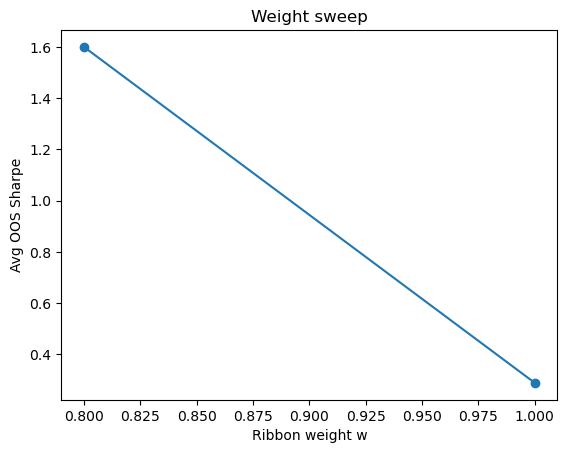

In [122]:
# Example: plot Sharpe vs weight for one pair

strategy_cond = (df_weight_profile['mavg_strategy'] == 'f16_s224_n8') & (df_weight_profile['donchian_strategy'] == 'en28_ex14_gFalse')
pair = df_weight_profile[strategy_cond]
# pair = df_weight_profile.query("mavg_strategy == 'f16_s224_n8' & donchian_strategy == 'en40_ex20_gFalse'")
plt.plot(pair["mavg_ribbon_weight"], pair["mean_sharpe"], marker="o")
plt.xlabel("Ribbon weight w"); plt.ylabel("Avg OOS Sharpe"); plt.title("Weight sweep")
plt.show()

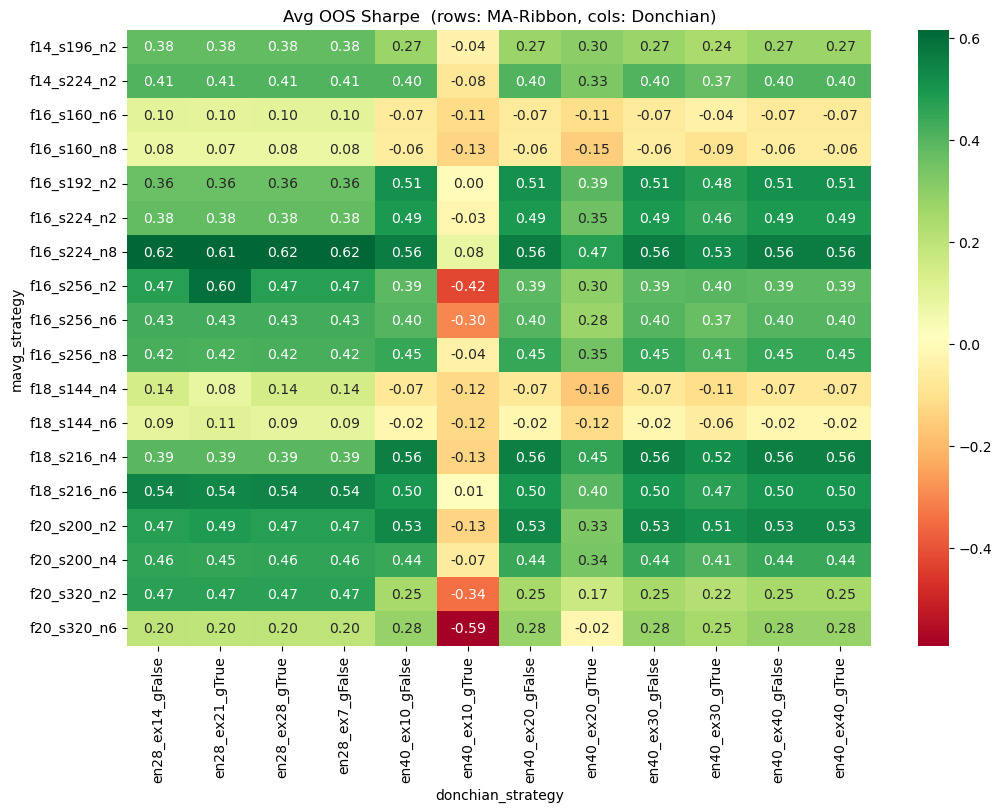

In [128]:
heat = df_performance_os_strategy_performance.pivot_table(
        index="mavg_strategy",
        columns="donchian_strategy",
        values="sharpe_mean")

import seaborn as sns, matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
sns.heatmap(heat, annot=True, fmt=".2f", cmap="RdYlGn")
plt.title("Avg OOS Sharpe  (rows: MA‑Ribbon, cols: Donchian)")
plt.show()

In [134]:
coin_cols = [c for c in df_performance_os.columns if c.endswith("_annualized_sharpe_ratio")]

coin_sharpe = (
    df_performance_os
    .groupby(["mavg_strategy", "donchian_strategy"])[coin_cols]
    .mean()
)

# Add the average cross‑coin dispersion
coin_sharpe["coin_sharpe_stdev"] = coin_sharpe.std(axis=1)
df_performance_os_strategy_performance = df_performance_os_strategy_performance.merge(coin_sharpe["coin_sharpe_stdev"],
                                                                                      on=["mavg_strategy","donchian_strategy"])

In [152]:
df_performance_os_strategy_performance.sort_values('strategy_score', ascending=False)

,mavg_strategy,donchian_strategy,sharpe_mean,sharpe_std,max_dd_mean,hit_rate,n_slices,strategy_score,coin_sharpe_stdev
74,f16_s224_n8,en28_ex28_gTrue,0.616187,1.115842,-0.256440,0.616187,4,-0.198174,0.168002
75,f16_s224_n8,en28_ex7_gFalse,0.616187,1.115842,-0.256440,0.616187,4,-0.198174,0.168002
72,f16_s224_n8,en28_ex14_gFalse,0.616187,1.115842,-0.256440,0.616187,4,-0.198174,0.168002
148,f18_s216_n4,en40_ex10_gFalse,0.555375,0.997791,-0.254732,0.555375,4,-0.198253,0.320715
150,f18_s216_n4,en40_ex20_gFalse,0.555375,0.997791,-0.254732,0.555375,4,-0.198253,0.320715
152,f18_s216_n4,en40_ex30_gFalse,0.555375,0.997791,-0.254732,0.555375,4,-0.198253,0.320715
154,f18_s216_n4,en40_ex40_gFalse,0.555375,0.997791,-0.254732,0.555375,4,-0.198253,0.320715
155,f18_s216_n4,en40_ex40_gTrue,0.555375,0.997791,-0.254732,0.555375,4,-0.198253,0.320715
73,f16_s224_n8,en28_ex21_gTrue,0.613305,1.116763,-0.256440,0.613305,4,-0.201517,0.164267
153,f18_s216_n4,en40_ex30_gTrue,0.521700,0.958558,-0.258644,0.521700,4,-0.216223,0.306523


In [146]:
final = (
    df_performance_os_strategy_performance
    .query("sharpe_mean > 1.0")           # your hurdle
    .query("max_dd_mean > -0.45")            # max 45 % drawdown
    .sort_values(["strategy_score", "coin_sharpe_stdev"], ascending=[False, True])
)

final.head(10)[["mavg_strategy","donchian_strategy","sharpe_mean","max_dd_mean","strategy_score"]]

,mavg_strategy,donchian_strategy,sharpe_mean,max_dd_mean,strategy_score


In [96]:
df_weight_profile[strategy_cond]

,mavg_strategy,donchian_strategy,mavg_ribbon_weight,mean_sharpe
22,f16_s224_n8,en28_ex14_gFalse,0.8,1.599653
23,f16_s224_n8,en28_ex14_gFalse,1.0,0.288365


In [80]:
pair

,mavg_strategy,donchian_strategy,mavg_ribbon_weight,mean_sharpe


In [56]:
df_performance_os_strategy_performance.nlargest(5, 'strategy_score')[['mavg_strategy','donchian_strategy']]

,mavg_strategy,donchian_strategy
72,f16_s224_n8,en28_ex14_gFalse
74,f16_s224_n8,en28_ex28_gTrue
75,f16_s224_n8,en28_ex7_gFalse
148,f18_s216_n4,en40_ex10_gFalse
150,f18_s216_n4,en40_ex20_gFalse


In [54]:
df_performance_os[(df_performance_os.mavg_strategy == 'f16_s224_n8') & (df_performance_os.donchian_strategy == 'en28_ex28_gTrue')]

,sampling_category,start_date,end_date,mavg_strategy,donchian_strategy,mavg_ribbon_weight,donchian_weight,annualized_return,annualized_sharpe_ratio,calmar_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count,BTC-USD_annualized_return,ETH-USD_annualized_return,SOL-USD_annualized_return,ADA-USD_annualized_return,AVAX-USD_annualized_return,BTC-USD_annualized_sharpe_ratio,ETH-USD_annualized_sharpe_ratio,SOL-USD_annualized_sharpe_ratio,ADA-USD_annualized_sharpe_ratio,AVAX-USD_annualized_sharpe_ratio,BTC-USD_annualized_std_dev,ETH-USD_annualized_std_dev,SOL-USD_annualized_std_dev,ADA-USD_annualized_std_dev,AVAX-USD_annualized_std_dev,BTC-USD_max_drawdown,ETH-USD_max_drawdown,SOL-USD_max_drawdown,ADA-USD_max_drawdown,AVAX-USD_max_drawdown
74,out_sample,2023-06-01,2023-11-30,f16_s224_n8,en28_ex28_gTrue,0.8,0.2,0.876251,1.599653,2.921789,0.500732,-0.299902,108 days,0.351852,1.143802,0.254403,240.0,0.111854,0.075470,0.485116,0.217032,0.101563,0.685398,0.342472,1.293473,1.994596,0.727494,0.128797,0.118699,0.365990,0.110041,0.114648,-0.029075,-0.024241,-0.226830,-0.017694,-0.029886
74,out_sample,2023-12-01,2024-05-31,f16_s224_n8,en28_ex28_gTrue,1.0,0.0,0.104999,0.352771,0.397185,0.606666,-0.264357,78 days,0.388889,0.299585,0.764880,262.0,0.068759,0.145494,0.286530,-0.053618,-0.078150,0.188140,0.648112,1.214807,-1.440665,-2.061761,0.226218,0.189107,0.215333,0.116151,0.107913,-0.116976,-0.079197,-0.093618,-0.039488,-0.044460
74,out_sample,2024-06-01,2024-11-30,f16_s224_n8,en28_ex28_gTrue,1.0,0.0,0.823386,1.360579,2.834063,0.616417,-0.290532,111 days,0.314815,0.972250,0.332385,202.0,0.108214,0.151670,-0.066128,0.241630,0.703227,0.506700,1.367445,-0.323817,1.584704,2.813036,0.172256,0.133516,0.338505,0.155484,0.259502,-0.103050,-0.017445,-0.171628,-0.079469,-0.047311
74,out_sample,2024-12-01,2025-05-31,f16_s224_n8,en28_ex28_gTrue,1.0,0.0,-0.189130,-0.848256,-1.106217,0.471063,-0.170970,129 days,0.155280,-0.440716,0.660013,98.0,0.040650,-0.004303,-0.089643,-0.002038,-0.002451,-0.019961,-2.752010,-1.736739,-1.074303,-0.796873,0.197433,0.054368,0.140382,0.102011,0.136368,-0.067096,-0.008295,-0.068958,-0.027849,-0.024575


In [66]:
df_performance_is_strategy_performance[(df_performance_is_strategy_performance.mavg_strategy == 'f16_s224_n8') & (df_performance_is_strategy_performance.donchian_strategy == 'en28_ex28_gTrue')]

,mavg_strategy,donchian_strategy,sharpe_mean,sharpe_std,max_dd_mean,hit_rate,n_slices
74,f16_s224_n8,en28_ex28_gTrue,-1.104588,0.323489,-0.780919,-1.104588,44


## Walk Forward Analysis with Only Best Pairs

In [155]:
import itertools

def generate_mavg_ribbon_donchian_channel_params():
    parameter_grid = {
        "mavg_ribbon_strategy": ['f16_s224_n2','f16_s224_n4','f16_s224_n6','f16_s224_n8','f18_s216_n2','f18_s216_n4','f18_s216_n6','f18_s216_n8'],
        "donchian_channel_strategy": ['en28_ex7_gFalse','en28_ex14_gFalse','en28_ex21_gFalse','en28_ex28_gFalse',
                                      'en28_ex7_gTrue','en28_ex14_gTrue','en28_ex21_gTrue','en28_ex28_gTrue',
                                      'en40_ex10_gFalse','en40_ex20_gFalse','en40_ex30_gFalse','en40_ex40_gFalse',
                                      'en40_ex10_gTrue','en40_ex20_gTrue','en40_ex30_gTrue','en40_ex40_gTrue']
    }
    keys, values = zip(*parameter_grid.items())
    for prod in itertools.product(*values):
        yield dict(zip(keys, prod))

In [175]:
def run_walk_forward_mavg_ribbon_donchian_ribbon_best_pairs(start_date, end_date, ticker_list):

    start_date = pd.Timestamp(start_date).date()
    end_date = pd.Timestamp(end_date).date()
    perf_cols = ['sampling_category', 'start_date', 'end_date', 'mavg_strategy', 'donchian_strategy', 'mavg_ribbon_weight', 'donchian_weight', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
                 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
    ticker_perf_cols = ['annualized_return', 'annualized_sharpe_ratio', 'annualized_std_dev', 'max_drawdown']
    perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])
    
    df_performance = pd.DataFrame(columns=perf_cols)
    
    IS_LEN = pd.DateOffset(years=2)
    OS_LEN = pd.DateOffset(months=6)
    start_date_is = start_date
    while True:
        end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_date_os = (end_date_is + pd.Timedelta(days=1))
        end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
        print(f'In Sample Start: {start_date_is}, In Sample End: {end_date_is}, Out of Sample Start: {start_date_os}, Out of Sample End: {end_date_os}')
        if end_date_os > end_date:
            break
    
        for params in generate_mavg_ribbon_donchian_channel_params():
            print(params)
            mavg_strategy_params = params['mavg_ribbon_strategy']
            donchian_strategy_params = params['donchian_channel_strategy']
            
            ## Moving Average Ribbon Params
            fast_mavg = int(mavg_strategy_params.split('_')[0][1:])
            slow_mavg = int(mavg_strategy_params.split('_')[1][1:])
            mavg_stepsize = int(mavg_strategy_params.split('_')[2][1:])
            
            ## Donchian Channel Params
            entry_window = int(donchian_strategy_params.split('_')[0][2:])
            exit_window = int(donchian_strategy_params.split('_')[1][2:])
            exit_gate = ast.literal_eval(donchian_strategy_params.split('_')[2][1:])
            
            print(mavg_strategy_params, donchian_strategy_params)
            print(fast_mavg, slow_mavg, mavg_stepsize, entry_window, exit_window, exit_gate)

            ## In Sample Dataframe
            print('Pulling In Sample Data!!')
            for w in np.linspace(0, 1, 21):
                w_mavg = round(w, 2)
                w_donchian = round(1 - round(w, 2), 2)
                print(f'M Avg Ribbon Weight: {w_mavg}, Donchian Channel Weight: {w_donchian}')
                df_is = apply_target_volatility_position_sizing_continuous_strategy(
                    start_date=start_date_is, end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                    mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
                    use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=w_mavg, donchian_signal_weight=w_donchian, long_only=long_only,
                    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                    annualized_target_volatility=annualized_target_volatility,
                    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)
                print('Calculating In Sample Asset Returns!!')
                df_is = calculate_asset_level_returns(df_is, end_date_is, ticker_list)

                ## In Sample Performance Metrics
                print('Getting In Sample Performance Metrics!!')
                row_parameters_is = {
                    'sampling_category': 'in_sample',
                    'start_date': start_date_is,
                    'end_date': end_date_is,
                    'mavg_strategy': mavg_strategy_params,
                    'donchian_strategy': donchian_strategy_params,
                    'mavg_ribbon_weight': w_mavg,
                    'donchian_weight': w_donchian
                }
                portfolio_perf_metrics_is = calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                   strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                                   passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

                print('Getting In Sample Asset Performance!!')
                for ticker in ticker_list:
                    ## In Sample
                    ticker_perf_metrics_is = perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                         strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                         annual_trading_days=365, include_transaction_costs_and_fees=False)
                    ticker_perf_metrics_is = {key: ticker_perf_metrics_is[key] for key in ticker_perf_cols}
                    ticker_perf_metrics_is = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_is.items()}
                    portfolio_perf_metrics_is.update(ticker_perf_metrics_is)
                
                row_parameters_is.update(portfolio_perf_metrics_is)
    
                ## Assign in sample metrics to performance dataframe
                df_performance.loc[df_performance.shape[0]] = row_parameters_is

            ## Get Moving Average and Donchian Channel Weights with best performing in-sample Sharpe Ratio
            in_sample_cond = (df_performance['sampling_category'] == 'in_sample')
            strategy_cond = (df_performance['mavg_strategy'] == mavg_strategy_params) & (df_performance['donchian_strategy'] == donchian_strategy_params)
            date_cond = (df_performance['start_date'] == start_date_is) & (df_performance['end_date'] == end_date_is)
            best_in_sample_mavg_weight = df_performance[in_sample_cond & strategy_cond & date_cond].sort_values('annualized_sharpe_ratio', ascending=False)['mavg_ribbon_weight'].iloc[0]
            best_in_sample_donchian_weight = df_performance[in_sample_cond & strategy_cond & date_cond].sort_values('annualized_sharpe_ratio', ascending=False)['donchian_weight'].iloc[0]
            
            ## Out of Sample Dataframe
            print('Pulling Out of Sample Data!!')
            df_os = apply_target_volatility_position_sizing_continuous_strategy(
                start_date=start_date_os, end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
                use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=best_in_sample_mavg_weight, donchian_signal_weight=best_in_sample_donchian_weight, 
                long_only=long_only, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)
            print('Calculating Out of Sample Asset Returns!!')
            df_os = calculate_asset_level_returns(df_os, end_date_os, ticker_list)
            
            ## Out of Sample Performance Metrics
            print('Pulling Out of Sample Performance Metrics!!')
            row_parameters_os = {
                'sampling_category': 'out_sample',
                'start_date': start_date_os,
                'end_date': end_date_os,
                'mavg_strategy': mavg_strategy_params,
                'donchian_strategy': donchian_strategy_params,
                'mavg_ribbon_weight': best_in_sample_mavg_weight,
                'donchian_weight': best_in_sample_donchian_weight
            }
            portfolio_perf_metrics_os = calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

            print('Getting Out of Sample Asset Performance!!')
            for ticker in ticker_list:
                ## Out of Sample
                ticker_perf_metrics_os = perf.calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_os = {key: ticker_perf_metrics_os[key] for key in ticker_perf_cols}
                ticker_perf_metrics_os = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_os.items()}
                portfolio_perf_metrics_os.update(ticker_perf_metrics_os)
            
            row_parameters_os.update(portfolio_perf_metrics_os)

            ## Assign out of sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_os

        start_date_is = (start_date_is + OS_LEN).date()
        
    return df_performance

In [177]:
start_date = pd.Timestamp('2021-06-01').date()
end_date = pd.Timestamp('2025-06-30').date()
perf_cols = ['sampling_category', 'start_date', 'end_date', 'fast_mavg', 'slow_mavg', 'mavg_stepsize', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
             'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
ticker_perf_cols = ['annualized_return','annualized_sharpe_ratio','annualized_std_dev','max_drawdown']
perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])

df_performance = pd.DataFrame(columns=perf_cols)

IS_LEN = pd.DateOffset(years=2)
OS_LEN = pd.DateOffset(months=6)
start_date_is = start_date
while True:
    end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
    start_date_os = (end_date_is + pd.Timedelta(days=1))
    end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
    print(f'In Sample Start: {start_date_is}, In Sample End: {end_date_is}, Out of Sample Start: {start_date_os}, Out of Sample End: {end_date_os}')
    if end_date_os > end_date:
        break
    start_date_is = (start_date_is + OS_LEN).date()

In Sample Start: 2021-06-01, In Sample End: 2023-05-31, Out of Sample Start: 2023-06-01, Out of Sample End: 2023-11-30
In Sample Start: 2021-12-01, In Sample End: 2023-11-30, Out of Sample Start: 2023-12-01, Out of Sample End: 2024-05-31
In Sample Start: 2022-06-01, In Sample End: 2024-05-31, Out of Sample Start: 2024-06-01, Out of Sample End: 2024-11-30
In Sample Start: 2022-12-01, In Sample End: 2024-11-30, Out of Sample Start: 2024-12-01, Out of Sample End: 2025-05-31
In Sample Start: 2023-06-01, In Sample End: 2025-05-31, Out of Sample Start: 2025-06-01, Out of Sample End: 2025-11-30


In [179]:
%%time
df_performance_1 = run_walk_forward_mavg_ribbon_donchian_ribbon_best_pairs(start_date=pd.Timestamp('2021-06-01').date(), end_date=pd.Timestamp('2023-11-30').date(), ticker_list=ticker_list)

In Sample Start: 2021-06-01, In Sample End: 2023-05-31, Out of Sample Start: 2023-06-01, Out of Sample End: 2023-11-30
{'mavg_ribbon_strategy': 'f16_s224_n2', 'donchian_channel_strategy': 'en28_ex7_gFalse'}
f16_s224_n2 en28_ex7_gFalse
16 224 2 28 7 False
Pulling In Sample Data!!
M Avg Ribbon Weight: 0.0, Donchian Channel Weight: 1.0
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
M Avg Ribbon Weight: 0.05, Donchian Channel Weight: 0.95
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!


KeyboardInterrupt: 

In [ ]:
df_performance_1.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_Performance_Best_Pairs-2021-06-01-2023-11-30.pickle')

In [ ]:
%%time
df_performance_2 = run_walk_forward_mavg_ribbon_donchian_ribbon_best_pairs(start_date='2021-12-01', end_date='2024-05-31', ticker_list=ticker_list)

In [ ]:
df_performance_2.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_Performance_Best_Pairs-2021-12-01-2024-05-31.pickle')

In [ ]:
%%time
df_performance_3 = run_walk_forward_mavg_ribbon_donchian_ribbon_best_pairs(start_date='2022-06-01', end_date='2024-11-30', ticker_list=ticker_list)

In [ ]:
df_performance_3.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_Performance_Best_Pairs-2022-06-01-2024-11-30.pickle')

In [ ]:
%%time
df_performance_4 = run_walk_forward_mavg_ribbon_donchian_ribbon_best_pairs(start_date='2022-12-01', end_date='2025-05-31', ticker_list=ticker_list)

In [ ]:
df_performance_4.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_Performance_Best_Pairs-2022-12-01-2025-05-31.pickle')